# Introduction

This notebook simulates fluid-structure interaction for fluid flowing in a channel past a leaflet (where the fluid-structure interaction is occuring). This is achieved via a monolithic formulation of the solution variables for the fluid and solid (see Chapter 3 of thesis for more detail). The fluid is assumed to be Newtonian, and the solid Hookean, and the equations are discretised using the finite-volume method. 

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import math
global eqs 
eqs=3
global dt
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# Define some classes

## Mesh Class

In [2]:
class Mesh:
    '''
    Constructs a "mesh" object with attributes detailing useful information about the mesh
    '''
    def __init__(self, Lx, Ly, Nx, Ny):
        
        self.Lx = Lx #length x direction
        self.Ly = Ly #length y direction
        self.Nx = Nx #no. of cells x direction
        self.Ny = Ny #no. of cells y direction
        self.dx = Lx/Nx #mesh spacing x direction
        self.dy = Ly/Ny #mesh spacing y direction
        self.M = int(Nx*Ny) #total no. of cells
        self.botleft = 0
        self.botright = (Nx-1) #cell ID of bottom right cell
        self.topleft = Nx*(Ny-1) #cell ID of top left cell
        self.topright = Nx*Ny-1 #cell ID of top right cell
        self.bot_cells = np.arange(1,Nx-1) #cell IDs of all bottom cells
        self.left_cells = np.arange(Nx,self.topleft,Nx) #cell IDs of all bottom cells
        self.right_cells = np.arange(2*Nx-1,Nx*Ny-1,Nx) #cell IDs of all bottom cells
        self.top_cells = np.arange(Nx*(Ny-1)+1,Nx*Ny-1) #cell IDs of all bottom cells
        
        
    def coordinates(self):
        '''
        gets x and y coordinates for all cell centres on mesh
        '''
        self.ycoord = np.arange(self.dy/2,Ly,self.dy, dtype=float) #cell centre coordinates
        self.xcoord = np.arange(self.dx/2,Lx,self.dx, dtype=float)
        

## Material Classes

### Fluid

In [3]:
class Fluid:
    '''
    Constructs a fluid object with attributes detailing useful information about the fluid
    '''
    def __init__(self, density, dynamic_viscosity, inlet_velocity):
        self.rho = density #fluid density
        self.mu = dynamic_viscosity #fluid dynamic viscosity
        self.vin = inlet_velocity
    def smoothing_coefficient(self, mesh, fluid, scaleFactor):
        '''
        Calculates the smoothing coefficients for the Rhie-Chow term in the solid and fluid continuity equations
        '''      
        
        #fluid momentum coeffs
        axf = fluid.mu*mesh.dy/mesh.dx
        ayf = fluid.mu*mesh.dx/mesh.dy
        apf = -2*(axf+ayf)

        #continuity equation
        Df = scaleFactor*mesh.dx*mesh.dy/apf    
        self.D = Df

### Solid

In [4]:
class Solid:
    '''
    Constructs a solid object with attributes detailing useful information about the solid
    '''
    def __init__(self, density, shear_modulus):
        self.rho = density #solid density
        self.shear = shear_modulus #solid shear modulus
        
    def define_solid_cells(self, mesh, pos, height):
        '''
        Defines the cell IDs of a 4mm leaflet positioned on the bottom wall of the channel that is half the
        height of the channel.
        
        Arguments:
            mesh: 'Mesh' object
            pos: fraction specifying percentage of channel length to position bottom left cell of leaflet
        Returns:
            solid_cells: cell IDs of every solid cell in domain
        '''

        frac = 0.004/Lx
        width = int(frac*Nx)
        
        height = math.floor(0.5*Ny) #height of block
        start = math.floor(Nx*pos)
        solid_cells = np.array(())
        for i in range(0,height): #solid block of width "width"
             #where block starts down channel
            solid_col = np.arange(start,start+width, 1)#build each column of solid cells
            solid_cells = np.append(solid_cells,solid_col)
            start +=Nx
            
        self.cells= solid_cells.astype(int)
        
        

    def smoothing_coefficient(self, mesh, solid, dt, scaleFactor):
        '''
        Calculates the smoothing coefficients for the Rhie-Chow term in the solid and fluid continuity equations
        '''
        #solid momentum coeffs
        axs = dt*solid.shear*mesh.dy/mesh.dx
        ays = dt*solid.shear*mesh.dx/mesh.dy
        aps = -2*(axs+ays)

        Ds = scaleFactor*mesh.dx*mesh.dy/aps
        self.D = Ds

## Result Class

In [5]:
class Result():
    '''
    Constructs result object for visualisation and analysis
    '''
    def __init__(self, value, name, unit):
        self.name = name
        self.unit = unit
        self.value = value
    
    def contourPlot(self, mesh):
        '''
        Creates contour plot of result
        '''
        X,Y = np.meshgrid(np.arange(0,mesh.Lx,mesh.dx),np.arange(0,mesh.Ly,mesh.dy))
        plot = np.reshape(self.value, (mesh.Ny, mesh.Nx))
        plt.figure(figsize=(18,3))
        plt.contourf(X,Y,plot,cmap='inferno')
        plt.colorbar(label="%s %s"%(self.name,self.unit))
        plt.title("%s Magnitude Distribution"%self.name, fontsize=15)

## Sparse Linear System Class


In [6]:
class LinearSystem():
    '''
    Creates necessary components to build a linear system using scipy library in python
    '''

    def __init__(self, mesh):

        self.b = np.zeros((eqs*mesh.M, 1)) #source vector
        numNonZeros = int(mesh.M*23) #max no. of nonzero coefficients for mesh
        self.coeffi = 0
        #CSR matrix
        self.data = np.zeros((numNonZeros)) #stores non zero matrix elements
        self.row_idx = np.zeros((numNonZeros )) #row position of matrix element in A
        self.col_idx = np.zeros((numNonZeros )) #column position of matrix element in A
    
    def sparsetoA(self, mesh):
        '''
        Creates compressed row matrix
        '''
        self.A = csr_matrix((self.data[0:self.coeffi+1], (self.row_idx[0:self.coeffi+1], \
                        self.col_idx[0:self.coeffi+1])), shape=(eqs*mesh.M,eqs*mesh.M))

        

## Cell Class

In [8]:
class Cell:
    '''
    Constructs a cell object with attributes detailing useful information about the cell
    '''
    def __init__(self, ID):
    
        self.ID = ID #cell ID in mesh
        self.beta_e = 1
        self.beta_w=1
        self.beta_n=1
        self.beta_s=1
        
        
    def cellMaterial(self, solid):
        '''
        Determines if a cell is a fluid or a solid
        '''
        if self.ID in solid.cells:
            self.type='solid'
            self.alpha = 0
        else:
            self.type='fluid'
            self.alpha = 1
            
    def cellInterfaces(self, solid, mesh):
        '''
        Determines if 4 sides of cell are FSI interfaces
        '''
        if ((self.type=='fluid' and self.ID+1 in solid.cells) or (self.type=='solid' and self.ID+1 \
                                not in solid.cells)): #check if neighbouring cell to east is a solid/fluid
            self.beta_e=0
           
        if ((self.type=='fluid' and self.ID-1 in solid.cells) or (self.type=='solid' and self.ID-1 \
                                not in solid.cells)): #check if neighbouring cell to west is a solid/fluid
            self.beta_w=0
            
        if ((self.type=='fluid' and self.ID+mesh.Nx in solid.cells ) or (self.type=='solid' and self.ID+mesh.Nx\
                                not in solid.cells)): #check if neighbouring cell to north is a solid/fluid
            self.beta_n = 0
            
        if ((self.type=='fluid' and self.ID-mesh.Nx in solid.cells ) or (self.type=='solid' and self.ID-mesh.Nx\
                                not in solid.cells)): #check if neighbouring cell to south is a solid/fluid
            self.beta_s = 0
            
        
        
    def cellPosition(self, mesh):
        
        '''
        Determines position of cell within mesh (i.e. if it is on a boundary (and what boundary))
        '''
        if self.ID in mesh.left_cells:
            self.pos = 'left'
            
        elif self.ID in mesh.right_cells:
            self.pos = 'right'
            
        elif self.ID in mesh.top_cells:
            self.pos = 'top'
        
        elif self.ID in mesh.bot_cells:
            self.pos = 'bot'
        
        elif self.ID == mesh.botleft:
            self.pos = 'botleft'
            
        elif self.ID == mesh.botright:
            self.pos = 'botright'
        
        elif self.ID == mesh.topleft:
            self.pos = 'topleft'
        
        elif self.ID == mesh.topright:
            self.pos = 'topright'
        else:
            self.pos='internal'
            
    def calculate_coefficients(self, mesh, fluid, solid, v, i, vis, D):
        '''
        Calculates the coefficients for the discretised momentum and continuity equation for a given cell

        Arguments:
            mesh: 'Mesh' object
            fluid: 'Fluid' object
            v: solution vector
            i: equation indexer
            vis, D: material property fields
        Returns:
            c: dictionary of all coefficients for this cells equations
        '''
        def harmonic_mean(x,y):
            return 2*x*y/(x+y)
        
       
    
        #pressure gradient momentum equation and velocity term continuity equation coefficients
        cx = (mesh.dy)/2
        cy = (mesh.dx)/2
        
        #initiate in case not called
        inlet_exp_c = 0 #explicit term at inlet for continuity equation
        inlet_exp_m = np.array([0,0]) #explicit term at inlet for momentum equation
        
        '''
        East
        '''

        if (self.ID in mesh.right_cells or self.ID==mesh.topright or self.ID == mesh.botright): #Right boundary cell 

            D_e = harmonic_mean(D[self.ID],D[self.ID]) #smoothing coefficient
            mu_e = harmonic_mean(vis[self.ID],vis[self.ID]) #diffusion coefficient material property
            F_e=-fluid.rho*mesh.dy*v[i]

        else: #East cell not a boundary
            D_e = harmonic_mean(D[self.ID],D[self.ID+1]) #smoothing coefficient
            mu_e = harmonic_mean(vis[self.ID],vis[self.ID+1]) #diffusion coefficient material propert
            F_e = -self.beta_e*float(fluid.rho*mesh.dy*(v[i+3]+v[i])/4) #convection term
            
        #coefficients
        d_E = mu_e*mesh.dy/mesh.dx #diffusive velocity term
        S_E = self.beta_e*D_e*mesh.dy/mesh.dx #implicit pressure gradient
        R_E = self.beta_e*D_e*mesh.dy/2 #explicit pressure gradient

        '''
        West
        '''
        if (self.ID in mesh.left_cells or self.ID==mesh.botleft or self.ID == mesh.topleft): #Left boundary cell 

            D_w = harmonic_mean(D[self.ID],D[self.ID]) #smoothing coefficient
            mu_w = harmonic_mean(vis[self.ID],vis[self.ID]) #diffusion coefficient material property
            F_w= 0
            inlet_exp_m = fluid.rho*mesh.dy*fluid.vin[0]*fluid.vin-2*fluid.mu*mesh.dy/mesh.dx*vin #explicit term added for inlet cells in momentum equation
            inlet_exp_c = fluid.vin[0]*mesh.dy #explicit term added for inlet cells in continuity equation

        else: #West cell not a boundary
            D_w = harmonic_mean(D[self.ID],D[self.ID-1]) #smoothing coefficient
            mu_w = harmonic_mean(vis[self.ID],vis[self.ID-1]) #diffusion coefficient material propert
            F_w = self.alpha*self.beta_w*float(fluid.rho*mesh.dy*(v[i-3]+v[i])/4)#explicit term added for inlet 
                                                                                 #cells in momentum equation
        #coefficients
        d_W = mu_w*mesh.dy/mesh.dx #diffusive velocity term
        S_W = self.beta_w*D_w*mesh.dy/mesh.dx #implicit pressure gradient
        R_W = self.beta_w*D_w*mesh.dy/2 #explicit pressure gradient

        '''
        North
        '''
    
        if (self.ID in mesh.top_cells or self.ID==mesh.topright or self.ID == mesh.topleft): #top boundary cell 

            D_n = harmonic_mean(D[self.ID],D[self.ID]) #smoothing coefficient
            mu_n = harmonic_mean(vis[self.ID],vis[self.ID]) #diffusion coefficient material property
            F_n=0

        else: #North cell not a boundary
            D_n = harmonic_mean(D[self.ID], D[self.ID+mesh.Nx]) #smoothing coefficient
            mu_n = harmonic_mean(vis[self.ID], vis[self.ID+mesh.Nx]) #diffusion coefficient material propert
            F_n = -self.alpha*self.beta_n*float(fluid.rho*mesh.dx*(v[i+3*mesh.Nx+1]+v[i+1])/4) #convection term
            
        #coefficients
        d_N = mu_n*mesh.dx/mesh.dy #diffusive velocity term
        S_N = self.beta_n*D_n*mesh.dx/mesh.dy #implicit pressure gradient
        R_N = self.beta_n*D_n*mesh.dx/2 #explicit pressure gradient

        '''
        South
        '''
    
        if (self.ID in mesh.bot_cells or self.ID==mesh.botright or self.ID == mesh.botleft): #Bottom boundary cell 

            D_s = 0 #smoothing coefficient = 0 zero at boundary not srue why
            mu_s = harmonic_mean(vis[self.ID],vis[self.ID]) #diffusion coefficient material property
            F_s=0

        else: #South cell not a boundary
            D_s = harmonic_mean(D[self.ID],D[self.ID-mesh.Nx]) #smoothing coefficient
            mu_s = harmonic_mean(vis[self.ID],vis[self.ID-mesh.Nx]) #diffusion coefficient material property
            F_s = self.alpha*self.beta_s*float(fluid.rho*mesh.dx*(v[i-3*mesh.Nx+1]+v[i+1])/4) #convection term
            
        #coefficients
        d_S = mu_s*mesh.dx/mesh.dy #diffusive velocity term
        
        S_S = self.beta_s*D_s*mesh.dx/mesh.dy #implicit pressure gradient
        
        R_S = self.beta_s*D_s*mesh.dx/2 #explicit pressure gradient    

        #cell P coefficients
        
        
        d_P = -(d_E+d_W+d_N+d_S)
        F_p = (F_e+F_w+F_n+F_s)
        S_P = -(S_E+S_W+S_N+S_S)
       
        c = {'d_E':d_E, 'd_W':d_W, 'd_N':d_N ,'d_S':d_S, 'F_e':F_e, 'F_w': F_w, 'F_n': F_n, 'F_s':F_s, 'cx':cx, \
            'cy':cy, 'S_E':S_E, 'S_W':S_W, 'S_N':S_N, 'S_S':S_S, 'R_E':R_E, 'R_W':R_W, 'R_N':R_N, 'R_S':R_S,\
             'd_P': d_P, 'F_p':F_p, 'S_P':S_P, 'inlet_exp_c': inlet_exp_c, 'inlet_exp_m': inlet_exp_m}
        
        self.c = c

### Internal Cell

In [9]:
class InternalCell(Cell):
    '''
    Child class to 'Cell' representing an internal cell
    '''
    def __init__(self, cellID):
        super().__init__(cellID)
    
    def momentumEquation(self, linear_sys, cell, i):
        '''
        Inserts the momentum equation to the linear system for an internal cell
        '''
            
        #X-MOMENTUM
        
        '''Velocity term'''
        def vpCoeff(linear_sys, i, cell):
            
            #vpx
            linear_sys.data[linear_sys.coeffi] = cell.c['d_P']+cell.c['F_p'] #d_P+F_p
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i

            linear_sys.coeffi+=1
            
            #vpy
            linear_sys.data[linear_sys.coeffi] = cell.c['d_P']+cell.c['F_p']
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+1

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def vwCoeff(linear_sys, i, cell):
            #vwx
            linear_sys.data[linear_sys.coeffi] = cell.c['d_W']+cell.c['F_w'] #d_W+F_w
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i-3

            linear_sys.coeffi+=1
            
             #vwy
            linear_sys.data[linear_sys.coeffi] = cell.c['d_W']+cell.c['F_w']  
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i-2

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def veCoeff( linear_sys, i, cell):
            
            #vex
            linear_sys.data[linear_sys.coeffi] = cell.c['d_E']+cell.c['F_e'] #d_E+F_e
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i+3

            linear_sys.coeffi+=1
            
            #vey
            linear_sys.data[linear_sys.coeffi] = cell.c['d_E']+cell.c['F_e']
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+4

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def vnCoeff( linear_sys, i, cell):
            
            #vnx
            linear_sys.data[linear_sys.coeffi] = cell.c['d_N']+cell.c['F_n'] #d_N+F_n
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i+eqs*Nx

            linear_sys.coeffi+=1

            #vny
            linear_sys.data[linear_sys.coeffi] = cell.c['d_N']+cell.c['F_n']
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+eqs*Nx+1

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def vsCoeff( linear_sys, i, cell):
            
            #vsx
            linear_sys.data[linear_sys.coeffi] = cell.c['d_S']+cell.c['F_s'] #d_S+F_s
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i-eqs*Nx

            linear_sys.coeffi+=1
            
            #vsy
            linear_sys.data[linear_sys.coeffi] = cell.c['d_S']+cell.c['F_s']
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i-eqs*Nx+1

            linear_sys.coeffi+=1
            
            return linear_sys
        
        '''Pressure Gradient'''
        
        def PwCoeff( linear_sys, i, cell):
           
            #Pw
            linear_sys.data[linear_sys.coeffi] = cell.c['cx']
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i-1

            linear_sys.coeffi+=1
            
            return linear_sys
            
        def PeCoeff( linear_sys, i, cell):
            #Pe
            linear_sys.data[linear_sys.coeffi] = -cell.c['cx']
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i+5

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def PnCoeff( linear_sys, i, cell):
           
            #Pn
            linear_sys.data[linear_sys.coeffi] = -cell.c['cy']
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+eqs*Nx+2

            linear_sys.coeffi+=1
            
            return linear_sys
            
        def PsCoeff(linear_sys, i, cell):
            #Ps
            linear_sys.data[linear_sys.coeffi] = cell.c['cy']
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i-eqs*Nx+2

            linear_sys.coeffi+=1
            
            return linear_sys
        
        #associate each variable with its function that inserts the variables linear_sys.coefficients appropriately
        var_functions={'vp':vpCoeff, 've':veCoeff, 'vw': vwCoeff, 'vn': vnCoeff, 'vs': vsCoeff,
                       'Pe':PeCoeff,'Pw':PwCoeff,'Pn':PnCoeff,'Ps':PsCoeff}
        
        #insert each variables linear_sys.coefficient
        for var in var_functions.keys():
            
            #avoid indexing errors at boundary
            if (cell.pos=='left'or cell.pos=='botleft' or cell.pos=='topleft') and (var=='vw' or var=='Pw' or var=='vp'): #don't insert P_west or v_west on left boundary
                continue
            elif (cell.pos=='right' or cell.pos=='botright' or cell.pos=='topright') and (var=='ve' or var=='Pe'or var=='vp' or var=='Pw'):
                continue
            elif (cell.pos=='top' or cell.pos=='topleft' or cell.pos=='topright') and (var=='vn' or var=='Pn'or var=='vp'):
                continue
            elif (cell.pos=='bot'or cell.pos=='botleft' or cell.pos=='botright') and (var=='vs' or var=='Ps'or var=='vp'):
                continue

            linear_sys = var_functions[var](linear_sys, i, cell)
            
        return linear_sys

            
    
    def continuityEquation(self, linear_sys, cell, i, gradP):

        def ueCoeff( linear_sys, i, cell):

            #vex
            linear_sys.data[linear_sys.coeffi] = cell.c['cx'] 
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i+3

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def vnCoeff( linear_sys, i, cell):
            #vny
            linear_sys.data[linear_sys.coeffi] = cell.c['cy']
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i+eqs*Nx+1

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def vsCoeff( linear_sys, i, cell):
            #vsy
            linear_sys.data[linear_sys.coeffi] =-cell.c['cy']
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i-eqs*Nx+1

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def uwCoeff( linear_sys, i, cell):
            #vwx
            linear_sys.data[linear_sys.coeffi] = -cell.c['cx']
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i-3

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def PwCoeff( linear_sys, i, cell):
            #Pw
            linear_sys.data[linear_sys.coeffi] = cell.c['S_W']
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i-1

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def PeCoeff( linear_sys, i, cell):
            #Pe
            linear_sys.data[linear_sys.coeffi] = cell.c['S_E']
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i+5

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def PnCoeff( linear_sys, i, cell):
            #Pn
            linear_sys.data[linear_sys.coeffi] = cell.c['S_N']
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i+eqs*Nx+2

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def PsCoeff( linear_sys, i, cell):
            #Ps
            linear_sys.data[linear_sys.coeffi] = cell.c['S_S'] 
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i-eqs*Nx+2

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def PpCoeff( linear_sys, i, cell):
            #Pp
            
            linear_sys.data[linear_sys.coeffi] = cell.c['S_P']  
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i+2

            linear_sys.coeffi+=1
            
            return linear_sys
        
        #associate each variable with its function that inserts the variables linear_sys.coefficients appropriately
        var_functions={'ue':ueCoeff, 'uw':uwCoeff, 'vn': vnCoeff, 'vs': vsCoeff,'Pp':PpCoeff,\
                       'Pe':PeCoeff,'Pw':PwCoeff,'Pn':PnCoeff,'Ps':PsCoeff}
        
        #insert each variables linear_sys.coefficient
        for var in var_functions.keys():
             #avoid inserting wrong linear_sys.coefficients for variables affected by boundary
            if (cell.pos=='left' or cell.pos=='botleft' or cell.pos=='topleft') and \
            (var=='uw' or var=='Pw' or var=='Pp'):  
               
                continue
                
            elif (cell.pos=='right' or cell.pos=='botright' or cell.pos=='topright') and \
            (var=='ue' or var=='Pe' or var=='Pp' or var=='Pw' or var=='Pn' or var=='Ps'):
                
                continue
                
            elif (cell.pos=='top'or cell.pos=='topright' or cell.pos=='topleft') and\
            (var=='vn' or var=='Pn' or var=='Pp'):
                
                continue
                
            elif (cell.pos=='bot'or cell.pos=='botleft' or cell.pos=='botright') and \
            (var=='vs' or var=='Ps' or var=='Pp') or (cell.type=='solid' and (var=='Pe' or var=='Pw' or var=='Pn')):
                
                continue
        
            linear_sys = var_functions[var](linear_sys, i, cell)
        
        #update continuity source term
        
        if cell.pos =='internal':
            j = int(cell.ID*2)
            linear_sys.b[i+2] = gradP[j+2]*cell.c['R_E']-gradP[j-2]*cell.c['R_W']\
                    +gradP[j+2*Nx+1]*cell.c['R_N']-gradP[j-2*Nx+1]*cell.c['R_S'] 
            #re*dPe-rw*dPw+rn*dPn-rs*dPs
            
        return linear_sys

### Inlet Cells

In [10]:
class LeftCell(InternalCell):
    '''
    Cell on left side boundary (channel inlet)
    '''
    def __init__(self, cellID):
        super().__init__(cellID)
    
    def momentumEquation(self, linear_sys, cell, i):
        
        #Add to source vector
        linear_sys.b[i] = cell.c['inlet_exp_m'][0] #x-mom
        linear_sys.b[i+1] = cell.c['inlet_exp_m'][1] #y-mom
        
        def vpCoeff( linear_sys, i, cell):
            
            #vpx
            linear_sys.data[linear_sys.coeffi] = cell.c['d_P']-cell.c['d_W']+cell.c['F_p'] #d_P+F_p
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i

            linear_sys.coeffi+=1
            
            #vpy
            linear_sys.data[linear_sys.coeffi] = cell.c['d_P']-cell.c['d_W']+cell.c['F_p']
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+1

            linear_sys.coeffi+=1
            
            return linear_sys
        
        def PpCoeff(linear_sys, i, cell):
            #Pp
            linear_sys.data[linear_sys.coeffi] = cell.c['cx'] 
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i+2

            linear_sys.coeffi+=1
            
            return linear_sys
        
        if cell.pos=='left': #only update vp linear_sys.coefficient in this manner for left cells (not left corners)
            linear_sys = vpCoeff(linear_sys, i, cell)
        
        linear_sys = PpCoeff(linear_sys, i, cell)
        
        return linear_sys
       
    def continuityEquation(self, linear_sys, cell, i, gradP):
        
        def PpCoeff( linear_sys, i, cell):

            #Pp
            linear_sys.data[linear_sys.coeffi] = -(cell.c['S_N']+cell.c['S_E']+cell.c['S_S']) #
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i+2

            linear_sys.coeffi+=1

            return linear_sys
        
        def vpCoeff( linear_sys, i, cell):

            #Pp
            linear_sys.data[linear_sys.coeffi] = cell.c['cx'] #
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i

            linear_sys.coeffi+=1

            return linear_sys

        linear_sys = vpCoeff( linear_sys, i, cell)
        
        if cell.pos=='left': #only update Pp for left cells
            linear_sys = PpCoeff(linear_sys, i, cell)
            
            #continuity source term
            j = cell.ID*2
            linear_sys.b[i+2] = cell.c['inlet_exp_c'] + gradP[j+2]*cell.c['R_E'] + gradP[j]*cell.c['R_E'] \
            + gradP[j+2*Nx+1]*cell.c['R_N'] -gradP[j-2*Nx+1]*cell.c['R_S'] #re*dPe+re*dPpx+rn*dPn-rs*dPs
        
        return linear_sys

### Bottom Cell

In [11]:
class BotCell(InternalCell):
    
    '''
    Cell on right side boundary (channel inlet)
    '''
    def __init__(self, cellID):
        super().__init__(cellID)
    
    def momentumEquation(self, linear_sys, cell, i):
        
        #vp
        def vpCoeff(linear_sys, i, cell):
            
            #vpx
            linear_sys.data[linear_sys.coeffi] = cell.c['d_P']-cell.c['d_S'] + cell.c['F_p'] #d_P-d_S+F_p (F_n=0 handled in linear_sys.coefficients function)
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i

            linear_sys.coeffi+=1
            
            #vpy
            linear_sys.data[linear_sys.coeffi] = cell.c['d_P']-cell.c['d_S'] + cell.c['F_p'] #d_P-d_S+F_p (F_n=0 handled in linear_sys.coefficients 
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+1

            linear_sys.coeffi+=1
            
            return linear_sys
        
        #Pp
        def PpCoeff(linear_sys, i, cell):
           
            linear_sys.data[linear_sys.coeffi] = cell.c['cy'] #
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+2

            linear_sys.coeffi+=1
            
            return linear_sys
        
        if cell.pos=='bot': #only update vp linear_sys.coefficient in this manner for left cells (not left corners)
            linear_sys = vpCoeff(linear_sys, i, cell)

        linear_sys = PpCoeff(linear_sys, i, cell)
        
        return linear_sys
        
    def continuityEquation(self, linear_sys, cell, i, gradP):

        def vpCoeff(linear_sys, i, cell):

            #vpy
            linear_sys.data[linear_sys.coeffi] = cell.c['cy']
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i+1

            linear_sys.coeffi+=1
            
            return linear_sys

        def PpCoeff(linear_sys, i, cell):

            #Pp
            linear_sys.data[linear_sys.coeffi] = -(cell.c['S_E']+cell.c['S_W'] +cell.c['S_N']) #
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i+2

            linear_sys.coeffi+=1

            return linear_sys

        if cell.pos=='bot' and cell.type=='fluid':
            linear_sys = PpCoeff(linear_sys, i, cell)
            
            j = int(cell.ID*2) #direction indexer
            
            linear_sys.b[i+2] = gradP[j+2]*cell.c['R_E'] - gradP[j-2]*cell.c['R_W'] + gradP[j+1]*cell.c['R_N'] \
                    + gradP[j+2*Nx+1]*cell.c['R_N']  #re*dPe-rw*dpW+rn*dPn+rn*dPpy

        linear_sys = vpCoeff(linear_sys, i, cell)
        
        return linear_sys

### Top Cell

In [12]:
class TopCell(InternalCell):
    '''
    Cell on right side boundary (channel inlet)
    '''
    def __init__(self, cellID):
        super().__init__(cellID)
    
    def momentumEquation(self, linear_sys, cell, i):
        
        #vp
        def vpCoeff( linear_sys, i, cell):
            
            #vpx
            linear_sys.data[linear_sys.coeffi] = cell.c['d_P']-cell.c['d_N'] + cell.c['F_p'] #d_P-d_N+F_p (F_n=0 handled in linear_sys.coefficients function)
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i

            linear_sys.coeffi+=1
            
            #vpy
            linear_sys.data[linear_sys.coeffi] = cell.c['d_P']-cell.c['d_N'] + cell.c['F_p'] #d_P-d_N+F_p (F_n=0 handled in linear_sys.coefficients 
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+1

            linear_sys.coeffi+=1
            
            return linear_sys
        
        #Pp
        def PpCoeff( linear_sys, i, cell):
           
            linear_sys.data[linear_sys.coeffi] = -cell.c['cy'] #
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+2

            linear_sys.coeffi+=1
            
            return linear_sys
        
        if cell.pos=='top':
            linear_sys = vpCoeff(linear_sys, i, cell)
            
        linear_sys = PpCoeff(linear_sys, i, cell)
        
        return linear_sys
        
    def continuityEquation(self, linear_sys, cell, i, gradP):
        
        def vpCoeff( linear_sys, i, cell):

            #vpy
            linear_sys.data[linear_sys.coeffi] = -cell.c['cy']
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i+1

            linear_sys.coeffi+=1
            
            return linear_sys

        def PpCoeff( linear_sys, i, cell):

            #Pp
            linear_sys.data[linear_sys.coeffi] = -(cell.c['S_E']+cell.c['S_W'] +cell.c['S_S'])#
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i+2

            linear_sys.coeffi+=1

            return linear_sys

        if cell.pos=='top':
            linear_sys = PpCoeff(linear_sys, i, cell)
            
            j = cell.ID*2 #direction pointer
            
            #continuity source term
            linear_sys.b[i+2] = gradP[j+2]*cell.c['R_E'] - gradP[j-2]*cell.c['R_W'] - gradP[j+1]*cell.c['R_S'] \
            -gradP[j-2*Nx+1]*cell.c['R_S'] #re*dPe-rw*dPw-rs*dPs-rs*dPpy

        linear_sys = vpCoeff(linear_sys, i, cell)
        
        return linear_sys
        

### Outlet Cell

In [13]:
class RightCell(InternalCell):
    '''
    Cell on right side boundary (channel inlet)
    '''
    def __init__(self, cellID):
        super().__init__(cellID)
    
    def momentumEquation(self,linear_sys, cell, i):
        
        #vp
        def vpCoeff( linear_sys, i, cell):
            
            #vpx
            linear_sys.data[linear_sys.coeffi] = -(cell.c['d_W']+cell.c['d_S']+cell.c['d_N'])+cell.c['F_p'] #-(d_E+d_S+d_N)-rhof*dy*u_P
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i

            linear_sys.coeffi+=1
            
            #vpy
            linear_sys.data[linear_sys.coeffi] = -(cell.c['d_W']+cell.c['d_S']+cell.c['d_N'])+cell.c['F_p']  #-(d_E+d_S+d_N)-rhof*dy*u_P
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+1

            linear_sys.coeffi+=1
            
            return linear_sys
        
        #Pw
        def PwCoeff( linear_sys, i, cell):
           
            #Pw
            linear_sys.data[linear_sys.coeffi] = (4/3)*cell.c['cx'] #
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i-1

            linear_sys.coeffi+=1
            
            return linear_sys
        
        if cell.pos=='right':
            linear_sys = vpCoeff(linear_sys, i, cell)
            
        linear_sys = PwCoeff(linear_sys, i, cell)
        
        return linear_sys
        
    def continuityEquation(self, linear_sys, cell, i, gradP):

        def vpCoeff( linear_sys, i, cell):

            #vpx
        
            linear_sys.data[linear_sys.coeffi] = cell.c['cx']
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i

            linear_sys.coeffi+=1
            
            return linear_sys

        linear_sys = vpCoeff(linear_sys, i, cell)
        
        return linear_sys
            
        
        

#### Bottom Left Cell

In [14]:
class BotLeftCell(LeftCell, BotCell):
    '''
    Cell in bottom left corner
    '''
    def __init__(self, cellID):
        super().__init__(cellID)
    
    def momentumEquation(self, linear_sys, cell, i):
        #vp
        def vpCoeff( linear_sys, i, cell):
            
            #vpx
            linear_sys.data[linear_sys.coeffi] = cell.c['d_P']-cell.c['d_S']-cell.c['d_W']+cell.c['F_p']
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i

            linear_sys.coeffi+=1
            
            #vpy
            linear_sys.data[linear_sys.coeffi] = cell.c['d_P']-cell.c['d_S']-cell.c['d_W']+cell.c['F_p'] #d_P-d_S-d_W+F_p 
                                                                        #(F_n=0 handled in linear_sys.coefficients function)
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+1

            linear_sys.coeffi+=1
            
            return linear_sys

        linear_sys = vpCoeff(linear_sys, i, cell)
        
        return linear_sys
        
    def continuityEquation(self, linear_sys, cell, i, gradP):

        def PpCoeff( linear_sys, i, cell):

            #Pp
            linear_sys.data[linear_sys.coeffi] = -(cell.c['S_W'] +cell.c['S_N'])
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i+2

            linear_sys.coeffi+=1

            return linear_sys

        linear_sys = PpCoeff(linear_sys, i, cell)
        
        j = int(cell.ID*2) #direction indexer
                               
        #dy*vinx+re*dPe+rn*dPn+re*dPpx+rn*dPpy
        linear_sys.b[i+2] = cell.c['inlet_exp_c'] + gradP[j+2]*cell.c['R_E'] + gradP[j+2*Nx+1]*cell.c['R_N'] \
                               +gradP[j]*cell.c['R_E'] + gradP[j+1]*cell.c['R_N']  

        return linear_sys
        
    


#### Top Left Cell

In [15]:
class TopLeftCell(LeftCell, TopCell):
    '''
    Cell in top left corner
    '''
    def __init__(self, cellID):
        super().__init__(cellID)
    
    def momentumEquation(self, linear_sys, cell, i):
        #vp
        def vpCoeff( linear_sys, i, cell):
            
            #vpx
            linear_sys.data[linear_sys.coeffi] = cell.c['d_P']-cell.c['d_N']-cell.c['d_W']+cell.c['F_p'] #d_P-d_S-d_W+F_p
                                                                        #(F_n=0 handled in linear_sys.coefficients function)
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i

            linear_sys.coeffi+=1
            
            #vpy
            linear_sys.data[linear_sys.coeffi] = cell.c['d_P']-cell.c['d_N']-cell.c['d_W']+cell.c['F_p'] #d_P-d_S-d_W+F_p 
                                                                        #(F_n=0 handled in linear_sys.coefficients function)
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+1

            linear_sys.coeffi+=1
            
            return linear_sys

        linear_sys = vpCoeff(linear_sys, i, cell)
        
        return linear_sys
        
    def continuityEquation(self, linear_sys, cell, i, gradP):

        def PpCoeff( linear_sys, i, cell):

            #Pp
            linear_sys.data[linear_sys.coeffi] = -(cell.c['S_W'] +cell.c['S_S'])
            linear_sys.row_idx[linear_sys.coeffi] = i+2
            linear_sys.col_idx[linear_sys.coeffi] = i+2

            linear_sys.coeffi+=1

            return linear_sys

        linear_sys = PpCoeff(linear_sys, i, cell)
        
        j = int(cell.ID*2)
        linear_sys.b[i+2] = cell.c['inlet_exp_c']+gradP[j+2]*cell.c['R_E'] - gradP[j-2*Nx+1]*cell.c['R_S'] \
        +gradP[j]*cell.c['R_E']-gradP[j+1]*cell.c['R_S']  #re*dPe-rs*dPs+re*dPpx-rs*dPpy
        return linear_sys


#### Top Right Cell

In [16]:
class TopRightCell(RightCell, TopCell):
    '''
    Cell on right side boundary (channel inlet)
    '''
    def __init__(self, cellID):
        super().__init__(cellID)
    
    def momentumEquation(self, linear_sys, cell, i):
        
        #vp
        def vpCoeff( linear_sys, i, cell):
            
            #vpx
            linear_sys.data[linear_sys.coeffi] = -(cell.c['d_W']+cell.c['d_S']+2*cell.c['d_N'])+cell.c['F_p'] #-(d_E+d_S+d_N)-rhof*dy*u_P
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i

            linear_sys.coeffi+=1
            
            #vpy
            linear_sys.data[linear_sys.coeffi] = -(cell.c['d_W']+cell.c['d_S']+2*cell.c['d_N'])+cell.c['F_p']  #-(d_E+d_S+d_N)-rhof*dy*u_P
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+1

            linear_sys.coeffi+=1
            
            return linear_sys
            
        linear_sys = vpCoeff(linear_sys, i, cell)
        
        return linear_sys
        
    def continuityEquation(self, linear_sys, cell, i, gradP):

        nothing_happens_here = 0
        return linear_sys

        
        

#### Bottom Right Cell

In [17]:
class BotRightCell(RightCell, BotCell):
    '''
    Cell on right side boundary (channel inlet)
    '''
    def __init__(self, cellID):
        super().__init__(cellID)
    
    def momentumEquation(self, linear_sys, cell, i):
        
        #vp
        def vpCoeff( linear_sys, i, cell):
            
            #vpx
            linear_sys.data[linear_sys.coeffi] = -(cell.c['d_W']+cell.c['d_N']+2*cell.c['d_S'])+cell.c['F_p'] #-(d_E+d_S+d_N)-rhof*dy*u_P
            linear_sys.row_idx[linear_sys.coeffi] = i
            linear_sys.col_idx[linear_sys.coeffi] = i

            linear_sys.coeffi+=1
            
            #vpy
            linear_sys.data[linear_sys.coeffi] = -(cell.c['d_W']+cell.c['d_N']+2*cell.c['d_S'])+cell.c['F_p']  #-(d_E+d_S+d_N)-rhof*dy*u_P
            linear_sys.row_idx[linear_sys.coeffi] = i+1
            linear_sys.col_idx[linear_sys.coeffi] = i+1

            linear_sys.coeffi+=1
            
            return linear_sys
            
        linear_sys = vpCoeff(linear_sys, i, cell)
        
        return linear_sys
        
    def continuityEquation(self, linear_sys, cell, i, gradP):

        nothing_happens_here = 0

        return linear_sys




# Helper Functions

In [18]:
def build_fields(solid, fluid, dt, mesh):
    '''
    Creates fields for fluid/solid density, fluid dynamic viscosity and solid shear modulus, and smoothing 
    coefficient. E.g. Indexing field at a solid cell ID will return a solid property
    
    Arguments:
        solid: 'Solid' object
        fluid: 'Fluid' object
        mesh: 'Mesh' object
        
    '''
    #Create material fields
    rho  = np.full(mesh.M,fluid.rho)
    rho[solid.cells] = solid.rho #fluid or solid density
    
    vis = np.full(mesh.M,fluid.mu)
    vis[solid.cells] = solid.shear*dt #shear or viscosity
    
    
    D = np.full(mesh.M, fluid.D)
    D[solid.cells] = solid.D #smoothing or viscosity
    
    return rho, vis, D


## Calculate Pressure Gradient Explicitly




In [19]:

def calculate_gradients(mesh, v):
    '''
    Calculates the pressure gradient at each cell centre explicitly for the last iteration to be used for momentum
    equation.
    
     Arguments:
        mesh: 'Mesh' object
        v: solution vector (u, v, p) of last iteration
    
    Returns:
        gradP: vector containing pressure gradient across each cell in x and y directions 
    '''
    
    eqs = 3 #3 equations (momentum x, y and continuity)

    '''
    Initialisation
    '''
    #initialise gradP vector (contains pressure gradient in x and y directions across each cell)
    gradP = np.zeros((2*mesh.M,1)) 
    
    '''
    Loop through all cells
    '''
    #Loop through each cell i
    for i,j in zip(range(0, eqs*mesh.M, eqs),range(0,2*mesh.M,2)):#i in steps of 3 (solution vector) and j in steps
                                                            #of 2 (gradP vector)
        #CORNERS
        #mesh.bottom left
        if i == 0:
            
            gradP[j]  = (v[i+5]-v[i+2])/(2*mesh.dx) # (1/2)*(dp/mesh.dx)e == (PE-PP)/2mesh.dx
            gradP[j+1] = (v[i+eqs*mesh.Nx+2]-v[i+2])/(2*mesh.dy) #(1/2)*(dp/mesh.dy)n == (PN-PP)/2mesh.dy
            
            
        #mesh.bottom right
        elif i == 3*mesh.botright:
                        
            gradP[j] = (2/(3*mesh.dx))*-v[i-1] # (PE-PW)/(3mesh.dx/2)
            gradP[j+1] = (v[i+eqs*mesh.Nx+2]-v[i+2])/(2*mesh.dy) #(1/2)*(dp/mesh.dy)n == (PN-PP)/2mesh.dy
            
            
        elif i == 3*mesh.topleft:
            gradP[j] = (v[i+5]-v[i+2])/(2*mesh.dx) #(1/2)*(dp/mesh.dx)e == (PE-PP)/2mesh.dy
            gradP[j+1] = (v[i+2]-v[i-eqs*mesh.Nx+2])/(2*mesh.dy) #(1/2)*(dp/mesh.dy)s == (PP-PS)/2mesh.dy
            
            
        #mesh.top right
        elif i == 3*mesh.topright:
            
            gradP[j] = (2/(3*mesh.dx))*-v[i-1] # (-PW)/(3mesh.dx/2)
            gradP[j+1] = (v[i+2]-v[i-eqs*mesh.Nx+2])/(2*mesh.dy) #(1/2)*(dp/mesh.dy)s == (PP-PS)/2mesh.dy
            
            
        #SIDES
        #mesh.bottom
        elif 0 < i < 3*mesh.botright:
            
            gradP[j] = (v[i+5]-v[i-1])/(2*mesh.dx) #(PE-PW)/2mesh.dx
            gradP[j+1] = (v[i+eqs*mesh.Nx+2]-v[i+2])/(2*mesh.dy) #(1/2)*(dp/mesh.dy)n == (PN-PP)/2mesh.dy
            
            
            
        #mesh.top
        elif 3*mesh.topleft < i < 3*mesh.topright:
                        
            gradP[j] = (v[i+5]-v[i-1])/(2*mesh.dx) #(PE-PW)/2mesh.dx
            gradP[j+1] = (v[i+2]-v[i-eqs*mesh.Nx+2])/(2*mesh.dy) #(1/2)*(dp/mesh.dy)s == (PP-PS)/2mesh.dy
            
            
        #left / Inlet
        elif i in range(eqs*mesh.Nx,3*mesh.topleft,eqs*mesh.Nx):
           
            gradP[j] = (v[i+5]-v[i+2])/(2*mesh.dx) #(1/2)*(dp/mesh.dx)e == (PE-PP)/2mesh.dx
            gradP[j+1] = (v[i+eqs*mesh.Nx+2]-v[i-eqs*mesh.Nx+2])/(2*mesh.dy) #(PN-PS)/2mesh.dy
            
            
        #right / Outlet
        elif i in range(3*mesh.botright+eqs*mesh.Nx,3*mesh.topright,eqs*mesh.Nx):
            
            gradP[j] = (2/(3*mesh.dx))*-v[i-1] # (-PW)/(3mesh.dx/2)
            gradP[j+1] = (v[i+eqs*mesh.Nx+2]-v[i-eqs*mesh.Nx+2])/(2*mesh.dy) #(PN-PS)/2mesh.dy
            
            
        else:
            gradP[j] = (v[i+5]-v[i-1])/(2*mesh.dx) #(PE-PW)/2mesh.dx
            gradP[j+1] = (v[i+eqs*mesh.Nx+2]-v[i-eqs*mesh.Nx+2])/(2*mesh.dy) #(PN-PS)/2mesh.dy
    
    
    return gradP

## Initialise Vectors

In [20]:
def initialiseVectors(mesh):
    '''
    Initialises vectors of appropriate length representing solution variables
    '''
    #Initialise unknown vectors
    #Solution vector
    v = np.zeros((eqs*mesh.M, 1)) #results vector
    vnew = np.zeros((eqs*mesh.M,1))
    
    #velocities and pressures
    vx = np.zeros((mesh.M, 1))#velocity x
    vxnew = np.zeros((mesh.M, 1)) #pressure
    vy = np.zeros((mesh.M, 1))#velocity y
    vynew = np.zeros((mesh.M, 1)) #pressure
    p = np.zeros((mesh.M, 1)) #pressure
    pnew = np.zeros((mesh.M, 1)) #pressure
    
    #displacements
    dispx = np.zeros((mesh.M,1))  #displacements x
    dispy = np.zeros((mesh.M,1)) #displacements y
    dispxold = np.zeros((mesh.M,1))  #old displacements x
    dispyold = np.zeros((mesh.M,1)) #old displacements y
    
    return v, vnew, vx, vxnew, vy, vynew, p, pnew, dispx, dispy, dispxold, dispyold

## Build Equations for Cell

In [21]:
def buildEquations(cell_obj, linear_sys, cell, i, gradP):
    '''
    Builds the momentum and continuity equations for a cell object
    '''
    #Build momentum Equation
    linear_sys = cell_obj.momentumEquation(linear_sys, cell, i)
    
    #Build continuity equation
    linear_sys = cell_obj.continuityEquation(linear_sys, cell, i, gradP)
    
    return linear_sys
    

## Build Coefficient Matrix

In [22]:
def assemble_matrix(mesh, fluid, solid, v, vis, D, gradP):
    
    '''
    Builds the coefficient matrix (A) for the problem

    Arguments:
        mesh: 'Mesh' object
        fluid: 'Fluid' object
        solid: 'Solid' object
        v: solution vector (u, v, p) of last iteration... used for convection term
    
    Returns:
        A: Coefficient matrix for current iteration
        b: Source vector for current iteration
    '''
    
    '''
    Initialisations
    '''
    linear_sys = LinearSystem(mesh)
        
    '''
    Build Linear System (A and b)
    '''
    #Loop through each cell i
    coeffi=0
    for i in range(0, eqs*mesh.M, eqs): #loop through each equation in each cell
        
        curr_cell_ID = int((i+1)/3) #get current cell ID
       
        '''
        Cell Object
        '''
        #create object representing current cell
        cell = Cell(curr_cell_ID)
        #find cell position
        cell.cellPosition(mesh)
        #find cell material
        cell.cellMaterial(solid)
        #determine if cell faces are FSI interfaces
        cell.cellInterfaces(solid, mesh)
        
        #calculate coefficients for this cell
       
        cell.calculate_coefficients(mesh, fluid, solid, v, i, vis, D)
        
        #instantiate an internal cell
        
        internal_cell = InternalCell(cell.ID)
        
        #build momentum and continuity equations for internal cell
        linear_sys = buildEquations(internal_cell, linear_sys, cell, i, gradP)
        
        '''
        Add to momentum and continuity equations for boundary cells
        '''

        if cell.pos=='internal': #skip conditionals for internal cell
            continue
        
        #LEFT CELLS
        elif ((cell.pos == 'left') or (cell.pos == 'botleft') or (cell.pos == 'topleft')): 
            left_cell = LeftCell(cell.ID) #create object for this left cell
            
            #build momentum and continuity equations for left boundary cell
            linear_sys = buildEquations(left_cell, linear_sys, cell, i, gradP)
            
            if cell.pos =='botleft':
                #bottom left
                bot_cell = BotCell(cell.ID)
                bot_left_cell = BotLeftCell(cell.ID) #create object for this bottom left cell
                
                #build momentum and continuity equations for bottom boundary cell
                linear_sys = buildEquations(bot_cell, linear_sys, cell, i, gradP)
                linear_sys = buildEquations(bot_left_cell, linear_sys, cell, i, gradP)
            
            if cell.pos =='topleft':
                #top left
                top_cell = TopCell(cell.ID)
                top_left_cell = TopLeftCell(cell.ID) #create object for this bottom right cell

                #build momentum and continuity equations for left boundary cell
                linear_sys = buildEquations(top_cell, linear_sys, cell, i, gradP)
                linear_sys = buildEquations(top_left_cell, linear_sys, cell, i, gradP)
            
        #RIGHT CELLS
        elif cell.pos == 'right' or cell.pos == 'botright' or cell.pos == 'topright': 
            
            right_cell = RightCell(cell.ID) #create object for this right cell
            
            #build momentum and continuity equations for right boundary cell
            linear_sys = buildEquations(right_cell, linear_sys, cell, i, gradP)
            
            if cell.pos=='botright':
                #botright
                
                bot_cell = BotCell(cell.ID)
                bot_right_cell = BotRightCell(cell.ID) #create object for this bottom right cell

                #build momentum and continuity equations for left boundary cell
                linear_sys = buildEquations(bot_cell, linear_sys, cell, i, gradP)
                linear_sys = buildEquations(bot_right_cell, linear_sys, cell, i, gradP)
                
            if cell.pos=='topright':
                #topright
                top_cell = TopCell(cell.ID)
                top_right_cell = TopRightCell(cell.ID) #create object for this bottom right cell

                #build momentum and continuity equations for left boundary cell
                linear_sys = buildEquations(top_cell, linear_sys, cell, i, gradP)
                linear_sys = buildEquations(top_right_cell, linear_sys, cell, i, gradP)
                
        #TOP CELLS
        elif cell.pos == 'top': 
            
            top_cell = TopCell(cell.ID) #create object for this top cell
            
            #build momentum and continuity equations for top boundary cell
            linear_sys = buildEquations(top_cell, linear_sys, cell, i, gradP)
                
        #BOTTOM
        elif cell.pos == 'bot': 
            bot_cell = BotCell(cell.ID) #create object for this bottom cell
            
            #build momentum and continuity equations for bottom boundary cell
            linear_sys = buildEquations(bot_cell, linear_sys, cell, i, gradP)
        

    #create csr matrix

    linear_sys.sparsetoA(mesh)

    
    
    return linear_sys.A, linear_sys.b
    





# Main Simulation


In [23]:

def FluidFlowinChannelwithLeaflet(Lx, Ly, Nx, Ny, rhof, mu, rhos, shear, max_its, scaleFactor, tol, dt, vin,\
                                  pos, height):
    
    '''
    Solves the conservation of momentum and mass laws using the finite volume method for a fluid flowing over 
    a solid obstacle, where fluid-structure interaction is occuring between the bodies.
    '''
    
    '''
    Create main objects
    '''
    #Mesh
    mesh  = Mesh(Lx, Ly, Nx, Ny) 
    print(mesh.botright)
    #Fluid
    fluid = Fluid(rhof, mu, vin)
    fluid.smoothing_coefficient(mesh, fluid, scaleFactor)#set fluid smoothing coefficient: fluid.D
    
    #Solid
    solid = Solid(rhos, shear)
    solid.smoothing_coefficient(mesh, solid, dt, scaleFactor)#set fluid smoothing coefficient: solid.D
    solid.define_solid_cells(mesh, pos, height)
    
    #get material property fields
    _, vis, D = build_fields(solid, fluid, dt, mesh)
    
    '''
    Initialise vectors used in calculation
    '''
    v, vnew, vx, vxnew, vy, vynew, p, pnew, dispx, dispy, dispxold, dispyold = initialiseVectors(mesh)
   
    #list of residuals for each unknown
    residualsvx = []
    residualsvy = []
    residualsp = []
    init_resvx = 1
    init_resvy = 1
    init_resp = 1
    
    print('Iters, Residual vx, Residual vy, Residual p')
    
    for iterations in range(1,max_its+1):
        
        
        #calculate gradP for new iteration
        gradP = calculate_gradients(mesh, v)
        
        #build new coefficient matrix
        A,b = assemble_matrix(mesh, fluid, solid, v, vis, D, gradP)
       
        #solve system
        vnew = scipy.sparse.linalg.spsolve(A,b)

        #get components of solution vector
        vxnew = vnew[0::3].reshape(mesh.M,1) #vx component
        vynew = vnew[1::3].reshape(mesh.M,1) #vy component
        pnew = vnew[2::3].reshape(mesh.M,1) #pressure component
        
        #calculate residuals
        resvx = np.linalg.norm(vxnew-vx)/init_resvx
        resvy = np.linalg.norm(vynew-vy)/init_resvy
        resp = np.linalg.norm(pnew-p)/(init_resp)
        
        #store residuals
        residualsvx.append(resvx)
        residualsvy.append(resvy)
        residualsp.append(resp)
        
        if (iterations==1):
            # Use a small number if the initial residual is small
            init_resvx = max(resvx, 1e-12)
            init_resvy = max(resvy, 1e-12)
            init_resp = max(resp, 1e-12)
            resvx = 1
            resvy = 1
            resp = 1
            
       
        #update solution
        vx = vxnew
        vy = vynew
        p = pnew
        v = vnew
        
        #update displacements
        dispx = dispxold+ vx*dt
        dispy = dispyold+vy*dt
        
        #print residuals
        print(iterations,resvx, resvy, resp, '\n')
        
        #break loop if tolerance reached
        if (resvx < tol and resvy<tol and resp<tol):
            print("tolerance reached in %i iterations"%(iterations+1))
            break
            
    #end of time step update old values
    dispxold = dispx
    dispyold = dispy  
    
    #get velocity magnitude
    vmag = np.sqrt(np.square(vx)+np.square(vy))
    
    disp = (np.sqrt(np.square(dispx.reshape(mesh.M,1))+np.square(dispy.reshape(mesh.M,1))))

    #Print the Reynolds Number
    Re = vin[0] * Ly *rhof/mu
    print("Reynolds Number =", Re)
    
    velocity = Result(vmag, 'Velocity', 'm/s')
    velocity.contourPlot(mesh)
    
    print("Maximum Velocity", np.max(vmag))
    print("Maximum Pressure", np.max(p))
    print("max solid disp",np.max(disp[solid.cells]))
    
    return A,b



## INPUT PARAMETERS

In [24]:
#DIMENSIONS
Lx = 0.2 #length channel x domain
Ly = 0.01 #length ch annel y domain
global Nx #number of cells in x domain
Nx = 800
 #cell length in x direction
Ny = 40 #number of cells in y direction

#solid block
pos = 0.5 #front face of solid block place (pos*Lx)m downstream of inlet
height = 0.5 #height of solid block (height*Ly)m high

#MATERIAL PROPERTIES
rhof = 1050 #fluid density
rhos = 1102 #solid density

mu = 3.5e-3 #fluid dynamic viscosity
shear = 1e6 #solid shear modulus

#OTHER PARAMETERS
max_its = 10#max iterations
tol = 1e-6 #residual tolerance
dt = 1 #time step
vin = np.array([0.1,0]) #input velocity
scaleFactor = 1 #smoothing coefficient scaling
vtk = False #export results to VTK foramat





799
Iters, Residual vx, Residual vy, Residual p
1 1 1 1 

2 0.22993037165343266 0.807492631154591 1.3462354990195564 

3 0.3179089633867702 0.6081884105716283 0.3503199438968752 

4 0.14745372575441304 0.29666124677855454 0.8710299285296063 

5 0.11061456130620487 0.21171548544934143 0.2040938359007301 

6 0.12201881266055145 0.27675784985180485 0.2293803783906633 

7 0.10399757018206625 0.2630704326471834 0.1683954366073734 

8 0.07231331172383983 0.1629476890189108 0.15587385124569092 

9 0.047918813567127974 0.11220376637715933 0.040939996155703456 

10 0.04494060682015374 0.12155612605855556 0.03739814707641453 

Reynolds Number = 300.0
Maximum Velocity 0.29764408793159125
Maximum Pressure 51.68161821754202
max solid disp 1.5101676907827904e-07


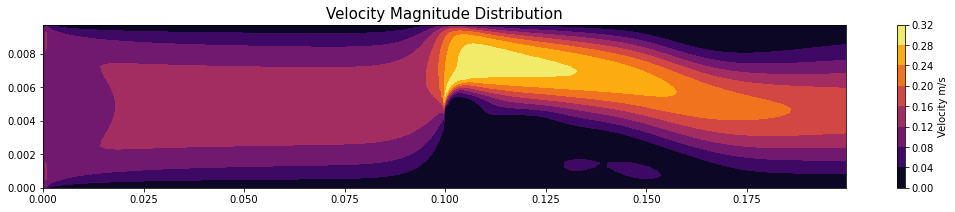

In [25]:
A,b=FluidFlowinChannelwithLeaflet(Lx, Ly, Nx, Ny, rhof, mu, rhos, shear, max_its, scaleFactor, tol, dt, vin, pos, height)